In [1]:
import torch
import torch_geometric as pyg
import torch.nn.functional as F
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time

dataset = QM9(root="./QM9") #Shuffleいらない？
#無向グラフの例
#edge_index = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long) # エッジの定義
#x = torch.tensor([[-1],[0],[1]], dtype=torch.float) # ノードの属性
#data = Data(x=x, edge_index=edge_index) # コンストラクタ
# Data(x=[3, 1], edge_index=[2, 4])

In [2]:
data = dataset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])

QM9の属性

x:ノードの特徴量(原子数×特徴量数=11)

y:ラベル(ラベル数)

z:原子番号(原子数)

edge_attr:エッジ特徴量=結合次数(エッジ数×結合次数)

edge_index:エッジリスト(2×エッジ数)

pos:3Dグリッドでの各原子の位置(原子数×3)

正則化の手法
・L1正則化(重み減衰)
・L2正則化(重み減衰)
・Dropout
・ラベル平滑化
・バッチ正則化
・

In [2]:
#https://www.graphcore.ai/posts/getting-started-with-pytorch-geometric-pyg-on-graphcore-ipus

# GCN
#NNでは64層くらい使ってる場合もある
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.linear1 = nn.Linear(16,1)
        self.out = nn.Linear(32, 1)
        #self.conv3 = GCNConv(32, dataset.num_classes) #num_classes:ラベルの数
    #バッチノルム(正則化)
    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        # Dropout:一定割合のノードを不活性化(0になる)させ、過学習を緩和する。pはゼロになるノードの確率で、0.5がデフォルト。
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch_geometric.nn.global_add_pool(x, batch) #これが必要やった
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

class GCN_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32):
        super().__init__()
        self.layer = layer
        self.dim = dim
        self.conv1 = GCNConv(dataset.num_node_features, self.dim)
        self.convn = GCNConv(self.dim, self.dim)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

In [ ]:
class GNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_net = torch.nn.Sequential(nn.Linear(dataset.num_edge_features, 32),
                                            nn.ReLU(),
                                            nn.Linear(32, dataset.num_node_features*32))
        self.conv2_net = torch.nn.Sequential(nn.Linear(dataset.num_edge_features, 32),
                                            nn.ReLU(),
                                            nn.Linear(32, 32*16))        
        self.conv1 = NNConv(dataset.num_node_features, 32, self.conv1_net)
        self.conv2 = NNConv(32, 16, self.conv2_net)
        self.linear1 = torch.nn.Linear(16, 32)
        self.out = nn.Linear(32,1)
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = torch_geometric.nn.global_add_pool(x, batch)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.out(x)
        return x

In [ ]:
#dipole予測　＋　ECFPのみ　＋　ECFP,dipole
#層とdimentionを増やすとどう変わるか
#NN:３層以上

In [22]:
#データの分割(total: 130831)
num_train, num_val = int(len(dataset)*0.6), int(len(dataset)*0.2)
num_test = len(dataset) - (num_train + num_val)
batch_size = 32

# 乱数の固定
device = torch.device("cpu")
pyg.seed_everything(seed=0)
"""
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
"""
train_set, valid_set, test_set = random_split(dataset, [num_train, num_val, num_test])

#Dataloaderの生成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=pyg.seed_everything(0))
valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(0))
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(0))

# GNNの初期化
model = GCN_N(2)
#model = GNNModel()
# 損失関数
criterion = F.mse_loss
# Optimizerの初期化
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



In [23]:
# 学習したいラベルのインデックス位置
target_idx = 1
loss_two_100 = []
for epoch in range(50):
    # train
    model.train()
    train_loss = 0
    total_graphs = 0
    for batch in train_loader:
        batch = batch.to("cpu")
        optimizer.zero_grad()
        prediction = model(batch)
        loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
        loss.backward()
        train_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_loss /=  len(train_loader) #損失の平均(batchあたり)

    # validation
    model.eval()
    valid_loss = 0
    total_graphs = 0
    with torch.inference_mode(): # 自動微分無効。torch.no_grad()よりさらに高速化
        for batch in valid_loader:
            prediction = model(batch)
            loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
            valid_loss += loss.item()
            total_graphs += batch.num_graphs
    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch+1} | train_loss:{train_loss}, valid_loss:{valid_loss}")
    loss_two_100.append({"Epoch":epoch + 1 , "train_loss":train_loss, "valid_loss":valid_loss})

Epoch 1 | train_loss:11.037600773956685, valid_loss:2.657016024904321
Epoch 2 | train_loss:9.16355091338247, valid_loss:5.170288771463781
Epoch 3 | train_loss:7.627838518139591, valid_loss:3.0186037275493875
Epoch 4 | train_loss:6.249329342235854, valid_loss:3.6385906101147527
Epoch 5 | train_loss:5.661841327131717, valid_loss:3.57902888840743
Epoch 6 | train_loss:5.346810289486307, valid_loss:3.4682826730616227
Epoch 7 | train_loss:5.156301436719607, valid_loss:3.6021196097499875
Epoch 8 | train_loss:4.944081609872851, valid_loss:4.021944329907667
Epoch 9 | train_loss:4.798447733864904, valid_loss:3.612897838240439
Epoch 10 | train_loss:4.7116281713230785, valid_loss:3.8956531125933735
Epoch 11 | train_loss:4.662381138370206, valid_loss:3.9230232585613187
Epoch 12 | train_loss:4.639834064094634, valid_loss:4.490722590378852
Epoch 13 | train_loss:4.635768491753545, valid_loss:3.873811492418602
Epoch 14 | train_loss:4.653484276473862, valid_loss:3.8879188500290103
Epoch 15 | train_loss:

In [24]:
loss_two_100

[{'Epoch': 1,
  'train_loss': 11.037600773956685,
  'valid_loss': 2.657016024904321},
 {'Epoch': 2, 'train_loss': 9.16355091338247, 'valid_loss': 5.170288771463781},
 {'Epoch': 3,
  'train_loss': 7.627838518139591,
  'valid_loss': 3.0186037275493875},
 {'Epoch': 4,
  'train_loss': 6.249329342235854,
  'valid_loss': 3.6385906101147527},
 {'Epoch': 5, 'train_loss': 5.661841327131717, 'valid_loss': 3.57902888840743},
 {'Epoch': 6,
  'train_loss': 5.346810289486307,
  'valid_loss': 3.4682826730616227},
 {'Epoch': 7,
  'train_loss': 5.156301436719607,
  'valid_loss': 3.6021196097499875},
 {'Epoch': 8,
  'train_loss': 4.944081609872851,
  'valid_loss': 4.021944329907667},
 {'Epoch': 9,
  'train_loss': 4.798447733864904,
  'valid_loss': 3.612897838240439},
 {'Epoch': 10,
  'train_loss': 4.7116281713230785,
  'valid_loss': 3.8956531125933735},
 {'Epoch': 11,
  'train_loss': 4.662381138370206,
  'valid_loss': 3.9230232585613187},
 {'Epoch': 12,
  'train_loss': 4.639834064094634,
  'valid_loss':

In [54]:
# お前はもう必要ない
import re
def parser(text):
    text = text.split("\n")
    loss = [{"train_loss":re.sub("train_loss:", "", i.split("| ")[1].split(",")[0]), "valid_loss":re.sub(" valid_loss:", "", i.split("| ")[1].split(",")[1])}for i in text if i]
    train_loss = [float(i["train_loss"]) for i in loss]
    valid_loss = [float(i["valid_loss"]) for i in loss]
    return np.array([train_loss, valid_loss])
loss_two = parser(two_layers)
loss_three = parser(theree_layers)

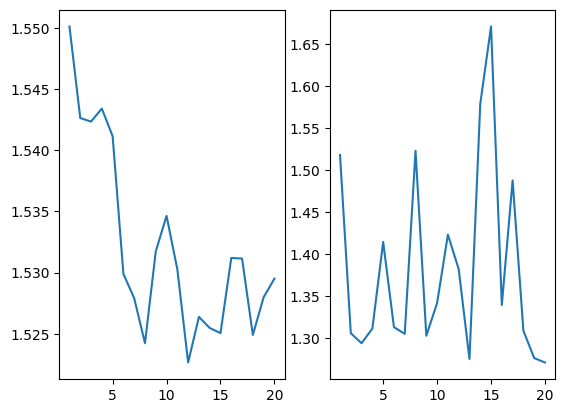

In [56]:
# 2層
import matplotlib.pyplot as plt
import math
epoch = [i for i in range(1, len(loss_two[0]) + 1)]
plt.subplot(1,2,1) 
loss_two = np.log(loss_two)
plt.plot(epoch, loss_two[0])
plt.subplot(1,2,2)
plt.plot(epoch, loss_two[1])

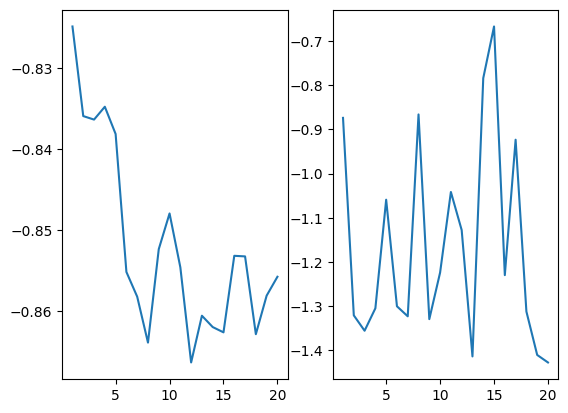

In [60]:
# 3層
import matplotlib.pyplot as plt
epoch = [i for i in range(1, len(loss_three[0]) + 1)]
loss_three = np.log(loss_three)
plt.subplot(1,2,1)
plt.plot(epoch, loss_three[0])
plt.subplot(1,2,2)
plt.plot(epoch, loss_three[1])

In [43]:
model.eval() # 評価開始
predictions = []
real = []
for batch in test_loader:
    output = model(batch.to("cpu"))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

plt.scatter(real, predictions)
plt.ylabel('Predicted')
plt.xlabel('real')
plt.show()


NameError: name 'model' is not defined

Creating Your Own Datasets

https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

https://qiita.com/maskot1977/items/4aa6322459eb3a78955f


Datasets

https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html


TORCH.NN.FUNCTIONAL

https://pytorch.org/docs/stable/nn.functional.html


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# エタンのグラフ構造の作成
mol = Chem.MolFromSmiles("CC")
mol = Chem.AddHs(mol)
atoms = mol.GetAtoms()
bonds = mol.GetBonds()
bonds[0].GetEndAtomIdx()

edge_list = []
for bond in bonds:
    edge_list.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    edge_list.append([bond.GetEndAtomIdx(),bond.GetBeginAtomIdx()])
edge_index = torch.tensor(edge_list) #エッジのリスト作成
x = torch.tensor([[atom.GetAtomicNum()] for atom in atoms]) # 原子番号

edge_attr = []
for bond in bonds:
    edge_attr.append([])
data = Data(x=x, edge_index=edge_index.t().contiguous())
data



In [ ]:
# グラフ構造の可視化
import networkx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
from IPython.display import SVG, display
data = dataset[4921]
nxg = to_networkx(data)

pagerank = networkx.pagerank(nxg) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(nxg,seed=0)

# 色指定
color_map = plt.get_cmap("tab10")
labels = data.x.numpy()
colors = [color_map(i) for i in labels]

svg = SVG(networkx.nx_agraph.to_agraph(nxg).draw(prog='fdp', format='svg'))
display(svg)

In [ ]:
# 学習したいラベルのインデックス位置
target_idx = 1

for epoch in range(50):
    model.train() #訓練モード
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    model.eval()
    for batch in valid_loader:
        output = model(batch)
        loss = criterion(output,batch.y[:, target_idx].unsqueeze(1)) #平方根で比較
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    
    val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {i} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")
    